# Evaluation of salt dilution stream gauging

This notebook guides you through the evaluation of the salt dilution stream gauging for the glaciology field course.  The idea is that you modify the code in this notebook such that your experiments are evaluated.

## Technical instructions

The notebook is a [Jupyter notebook](https://jupyter.org/) (formerly iPython notebook) which allows combining notes (in [markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)), codes and plots.  For documentation see [here](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Notebook%20Basics.html), but you should be able to get by with the documentation I provide below. 

To get the notebook running (what you're looking at right now is probably the non-inteactive html-rendered version of the notebook) do:

- log into the practicum account on a linux machine
- open a terminal and type: `cd fieldcourse/surface-hydrology/` + enter, `julia` + enter
- once started type `using IJulia` + enter and `notebook()` + enter (this will take a few seconds).
- this should open a file-browser dialog in your internet-browser (if it doesn't open a browser and navigate to [localhost:8888](http://localhost:8888), by clicking the link).  Click on `Salt-dilution.ipynb` which should open a new tab.  The tab should look like the html-version of the notebook you looked at so far but is now fully functional, i.e. you can edit it and exectue code. 

If you want to run this on your own computer you'll have to install [Julia](http://www.julialang.org/downloads) and install the packages `IJulia`, `NBInclude`, `PyPlot`, `LsqFit`, `CSV` by running at the Julia prompt: `using Pkg; [Pkg.add(s) for s in ["IJulia", "NBInclude", "PyPlot", "LsqFit", "CSV"]]`.

The important **notebook commands** are:

- clicking or double-clicking into a cell allows you to edit it.
- pressing **shift+enter** evaluates it: for a cell like the one you are reading now it renders the markdown, for code cells it evaluates the code and prints/displays the output of the last line of code.  Use a `;` to supress the output.
- variables and functions defined in one cell will be available for use in cells evaluated afterwards (irrespective of whether the cell is above or below).
- if you change a code-cell and re-evaluate it, the cells depending on its variables are not evaluated again automatically.
- somtimes it is good to re-start the computation and re-evaluated all cells. Go to drop down menu `Kernel -> Restart and run all`
- there is **no undo**! E.g. if you mark the contents of a cell and press backspace, it's gone, bye-bye!  Thus save often (disk-icon top left).  It should also auto-save but still, save often.  To revert to the last save go to menu `File -> Revert to Checkpoint` (this is as close to undo as it gets!).
- To insert a new, empty cell got to the menu `Insert`
- To change the type of the cell use the drop-down menu which displays `Code` by default.
- To export the notebook as a pdf, html, etc. got to drop-down menu `File -> Download as`. (Note, to save single figures, you can use the command `savefig("example.png")`.)

Plots: to export plots it may be easiest if you right-click on it an choose "Save image as".

## Julia

This notebook uses the Julia programming language, which is a new technical programming language.  Its syntax is fairly close to Matlab and not far off Python, at least for easy stuff, to which I'll stick to here.  Notable differences to Matlab are:

- indexing is done with `[]`, e.g. `a[3]`.
- functions can be defined in-line and don't need their own m-file

Differences to python:

- indexing starts at 1
- indentation does not matter, instead blocks/functions, etc are closed with `end`.


Documentation for Julia can be found [here](http://docs.julialang.org).  If you're interested to get started with Julia (which I can reccommend) have a look at [these](https://www.youtube.com/playlist?list=PLP8iPy9hna6SCcFv3FvY_qjAmtTsNYHQE) video tutorials, or above docs.

# Evaluating Salt-Dilution Experiments

Quite a few things need to come together to get the discharge out of the salt-dilution measurements you conducted.  The steps are:
- process the calibration data to get a relation between sensor readout and salt concentration
- read-in the files of the conductivity meter and slice them into the individual traces
- calculate the discharge by integrating the time series of concentration and dividing it through the injected salt mass

## Let's get started

First load the plotting library [PyPlots.jl](https://github.com/stevengj/PyPlot.jl) and the helper functions in the notebook `Salt-dilution-helper-functions.ipynb` (If you want to look at it, it's in the same directory as this file. You can open it by clicking it in the file-browser tab.  Clicking [here](http://localhost:8888/notebooks/Salt-dilution-helper-functions.ipynb) should also open it.  Once opened you can edit it too.)

In [1]:
# Import the plotting package "PyPlot" and makes its functions available.
using PyPlot

# Some standard libraries
using Dates, Statistics

# Include a notebook-file which contains misc. helper functions
# (in the same directory as this notebook).  You can open it by clicking on it in the file-browser.
using NBInclude
@nbinclude("Salt-dilution-helper-functions.ipynb");

## Calibration data

You performed several calibrations.  The purpose of these was to be able to convert a sensor readout (usually a conductivity) into a salt concentration (in g/l).  So we're after a function `readout -> concentration`.  Let's get started:

Adapt below cell to contain your calibration results:

- the `bucketsize` is the size of the bucket/bottle in which you preformed the calibration (in liters).
- the `solution` is the concentration of the calibration solution (in g/l).
- The `cali1`, etc., variables should contain total $ml$ calibration solution added (first column) and readout in $μS/cm$ (second column).

In [15]:
# UPDATE these two variables if needed!!!
bucketsize = 1.0 # calibration bucket size in liters
solution = 10.0 # calibration solution concentration (g/l)

# total calibration ml solution vs sensor readout (μS/cm)
# NOTE: this is bongus data.  Yours will look quite differenly!

# first calibration on 30.8.2016 at 15:34
cali1 = [ 0 331 # First row needs to be the background reading!
          1 351 # Note, that background reading will probably be much different for you
          3 392
          5 430
         10 524]
# second calibration 31.8.2016
cali2 = [ 0 320
          1 349
          3 387
          5 426
         10 520
         20 701] 
# more calibarations
# cali3 = ...

# to supress output add this semicolon:
;

In [16]:
"""
Converts ml added to bucket to a concentration (g/l == kg/m^3).

Input:

- ml -- how many mililiters were added
- solution -- the concentration of the calibration solution (kg/m^3 == g/l)
- bucketsize -- the size of the bucket/bottle to which the solution was added (l)

Output:

- concentration (kg/m^3 == g/l)
"""
function ml_to_concentration(ml, solution, bucketsize)
    mass = ml/1e3 * solution # salt mass added to bucket (g)
    return mass/bucketsize # concentration in g/l (== kg/m^3)
end
# For example, convert cali1[:,1] to concentration (g/l):
ml_to_concentration(cali1[:,1], solution, bucketsize)

5-element Array{Float64,1}:
 0.0 
 0.01
 0.03
 0.05
 0.1 

What we are really after is a function which tells us the concentration for a given sensor readout.  This is done with the `fit_calibration` function which is contained in the extra file [`Salt-dilution-helper-functions.ipynb`](Salt-dilution-helper-functions.ipynb), which was loaded in the first cell with the `nbinclude` command. (You can treat it as a black-box but feel free to look at it by clicking the link or via the file-browser).  Running this returns us just such a function, by fitting a straight line through the data:

$ f(x) = ax $

where $x$ is difference between the readout and the readout at 0 concentration, and $a$ is the parameter to fit.
It will also tell you how good the fit is by giving the error on `a`. The error should be "reasonably" small.

In [17]:
# Fit a straight line through the calibrations 
# (executing this the first time will take ~10s, a "In [*]" on the side of the cell indicates that julia is
#  doing calculations)
#
# Returns a function: f(cond-cond_at_0) -> concentration
delta_cond2conc = fit_calibration(bucketsize, solution, cali1, cali2);

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000514±1.35e-5



**Aside:** Note that for most functions, including the ones in the `Salt-dilution-helper-functions.ipynb` file, help can be printed by typing `?fit_calibration` (as the only thing in a cell):

In [5]:
?fit_calibration

search: fit_calibration



```
fit_calibration(bucketsize, solution, calis...)
```

Fits a line of best fit through the calibration data going through the origin.   Returns the function of this line: `f(cond-cond_at_0) -> concentration`.

Also prints the parameters values +/- 95% confidence intervals.

Uses the package LsqFit: https://github.com/JuliaOpt/LsqFit.jl




With `delta_readout2conc` we now have a function which converts the sensor readout (above background, thus the `delta_` in its name) to a salt concentration, just what we need further down!  Let's have a look at how well the line fits the data by plotting it:

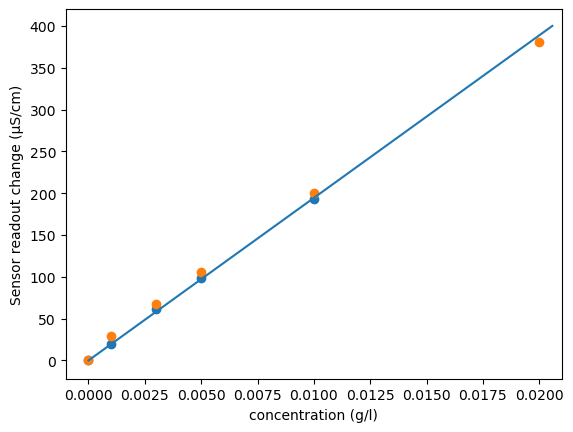

In [6]:
## Plot the calibration points:

# Note if you want a zoom-able plot opening in a new window do:
#pygui(true)
# to go back to in-line plots do
#pygui(false)

# scatter plots (x,y) points
fig = figure()
scatter(ml_to_concentration(cali1[:,1], solution, bucketsize), cali1[:,2].-cali1[1,2], 
        label="Calibration 1")
xlabel("concentration (g/l)")
ylabel("Sensor readout change (μS/cm)")
scatter(ml_to_concentration(cali2[:,1], solution, bucketsize), cali2[:,2].-cali2[1,2],
         label="Calibration 2")
# add more plots of calibrations here by copy-pasting-adapting the cali2 plot...

## Now plot the line of best fit:
readouts = range(0,stop=400,length=100)
# (plot plots a line)
plot(delta_cond2conc(readouts), readouts, label="line of best fit")
xlim((-0.001,0.021));

savefig("../plots/calibration.png") # to save this figure to a file, useful for your presentation

That's the calibrations done. If you got several quite different calibration results, say from the proglacial stream and the supraglacial stream, then use only their respecive calibrations for a set of traces.

## Load the data file

The datafile has the format:
```
Device;Device serial;ID;Date/Time;Value;Unit;Mode;Value2;Unit2;Mode2;Measurement;Calibration;Additional;Sensor;Sensor serial;User
Multi 3630; 16231200;2;12.08.2016 13:36:58;0.1;µS/cm;Cond;25.6;°C;Temp;;;C = 0.475 1/cm   Tref25   nLF;TetraCon 925-P; 16210277;
...
```
We're interested in columns: time, conductivity (`µS/cm`), and temperature (potentially useful to check that the sensor was in the water).  The loading is implemented in the function `read_conductivity_data` in the notebook [`Salt-dilution-helper-functions.ipynb`](Salt-dilution-helper-functions.ipynb), which was loaded above.  Again you can treat that function as a black-box (or not).  First check its documentation:

In [7]:
?read_WTW

search: read_WTW



```
read_WTW(filename)
```

This function reads a file from the WTW conductivity sensor and returns:

Dict with keys: :t [date-time stamp], :cond [μS/cm], :temp [C]

Note, that the input file usually contains several traces.  Split them up with  `split_conductivity_data`.


In [8]:
@nbinclude("Salt-dilution-helper-functions.ipynb");
out_WTW = read_WTW("../data/example_raw/AD281106_example.CSV")
traces = split_conductivity_data_timegap(out_WTW, maxtemp=50, mincond=200) # note maxtemp=50 was used to account for warm tap-water
                                                                           # mincond is to discount the air-values
# if there are several files, then repeat above for each.
;

Let's plot the loaded data:

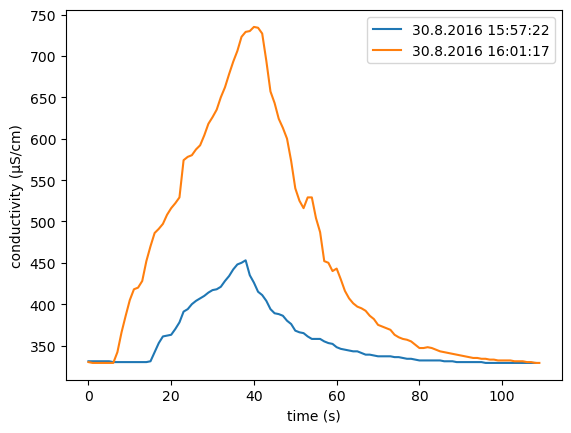

PyObject <matplotlib.legend.Legend object at 0x7f7b404840d0>

In [9]:
figure()
for tr in traces
    plot(tr[:t], tr[:cond], 
          label=Dates.format(tr[:tstart], "d.m.yyyy HH:MM:SS") )
end
xlabel("time (s)")
ylabel("conductivity (μS/cm)")
legend()

This is bongus data (produced by holding the conductivity sensor into a glas, then adding salt and then diluting).  Your breakthrough curve should look much smoother!

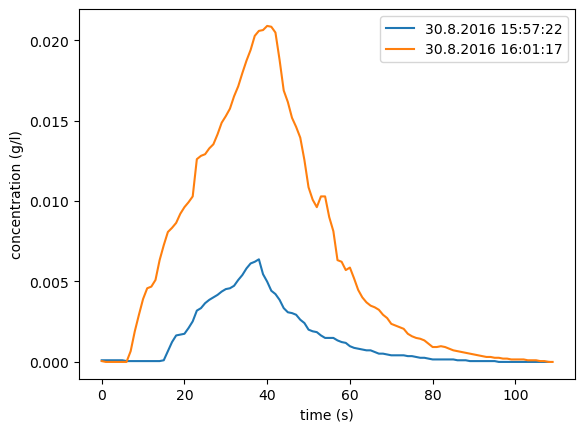

PyObject <matplotlib.legend.Legend object at 0x7f7b4040af10>

In [10]:
# Now plot the concentrations
figure
for tr in traces
    plot(tr[:t], delta_cond2conc(tr[:cond].-tr[:cond][end]), # note that I subtract the background reading!
          label=Dates.format(tr[:tstart], "d.m.yyyy HH:MM:SS") )
end
xlabel("time (s)")
ylabel("concentration (g/l)")
legend()

## Determine discharge of one dilution experiment

Now that we have the data loaded, we can determine the discharge.  The concentration $C$ times the (unknown) stream discharge $Q$ gives the salt mass flux.  Integrate this over the the whole breakthrough curve to get the injected mass $M$:

$ M = Q \int C \, d t$

This assumes that $Q$ is constant during the salt passage (a good assumption).  Solve for the unknow $Q$:

$ Q = \frac{M}{\int C \, d t}$.

This is what we calculate here.


First define the functions doing this integral.  (Note that the string in `"""` defines the help-text which could be queried with `?integrate_concentration`.)

In [11]:
"""
    integrate_concentration(t, conc, t1=0.0, t2=Inf)

Integrates the concentration time series.

Input:
- t -- times (s)
- t1, t2 -- integrate from t1 to t2.  Note that the concentration should be 
            close to zero at both t1 and t2 as we want to integrate over the whole curve.
- conc -- concentration (g/l) time series (convert conductivity with f_readout2conc 
          to a concentration)

Output:

- integrated concentration (g s/l) == (kg s/ m^3)
"""
function integrate_concentration(t, conc, t1=0.0, t2=Inf)
    inds = findfirst(t.>=t1):findlast(t.<=t2)
    dt = t[2]-t[1]
    out = sum(conc[inds]*dt) # approximate the integral by a sum
    return out
end
    
"""
    calcQ(trace, t1=0.0, t2=Inf, delta_cond2conc=delta_cond2conc)

Calculate discharge from sensor readout.  Taks as background the mean of the first 5 and last 10 point
(if those are off then you need to cut them).

Input:
- trace -- time series of sensor readout, including a field `:mass` with mass of salt injected

Optional:
- t1,t2 -- integration limits (otherwise the whole series is integrated)
- delta_readout2conc -- if you got several `delta_readout2conc` functions, then
                        pass it in explicitly.

Output:
- discharge Q (m^3/s)
"""
function calcQ(trace, t1=0.0, t2=Inf, delta_cond2conc=delta_cond2conc)
    t, cond = trace[:t], trace[:cond]
    i1, i2 = findfirst(t.>=t1), findlast(t.<=t2)
    delta_cond = cond .- mean(cond[[i1:5;i2-10:i2]])
    conc = delta_cond2conc(delta_cond)
    return trace[:mass]/integrate_concentration(t, conc, t1, t2)
end;

Now let's use this to finally calculate the discharge:

In [12]:
# You need to update this to reflect your salt injection masses:
masses = [0.1, 0.05]
for (i,tr) in enumerate(traces)
    tr[:mass] = masses[i]
end
# Integration boundaries.  If the sensor was submerged before logging started, then
# you can probably delete t1s and t2s (also in below loop).  If not, like in the fake-examples below,
# the boundaries need to be set to avoid integrating the negative concentrations from 0-15s.
#t1s = [15, 15]
#t2s = [Inf, Inf]

# Store the times and discharges
ts = DateTime[]
Qs = Float64[]  # this will contain the discharges
for i = 1:length(traces)
    Q = calcQ(traces[i]) #, t1s[i], t2s[i]) # in m^3/s
    if Q<1000
        println("Discharge for experiment $i is $(round(Q*1000,sigdigits=2)) l/s")
    else
        println("Discharge for experiment $i is $(round(Q,sigdigits=2)) m^3/s")
    end
    push!(Qs, Q)
    push!(ts, traces[i][:tstart])
end;

Discharge for experiment 1 is 650.0 l/s
Discharge for experiment 2 is 72.0 l/s


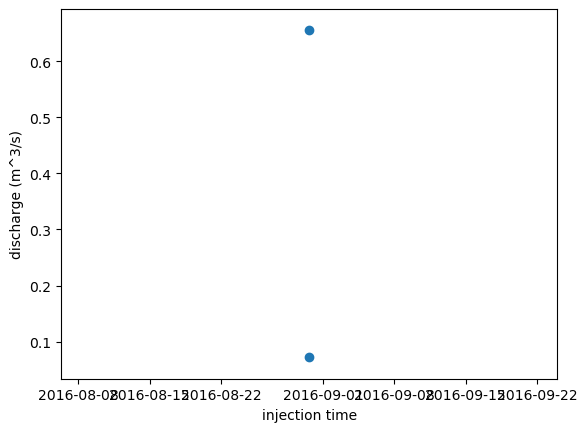

PyObject Text(24.000000000000007, 0.5, 'discharge (m^3/s)')

In [13]:
# plot the discharge vs time:
scatter(ts, Qs)
# scatter(string.(ts), Qs) # might be better?
xlabel("injection time")
ylabel("discharge (m^3/s)")

## Store output in text files

In case you want to process this further in the programming language of your choice.

In [14]:
using DelimitedFiles: writedlm
# store discharge and time in a csv file
out = hcat(ts, Qs)
writedlm("../data/example_pro/discharge.csv", out) # this will write the date-time in ISO format, which should be easy to read-in

# if you prefer this writes it as days since some date:
out = hcat(datetime2julian.(ts), Qs)
writedlm("../data/example_pro/discharge-julian.csv", out)

# More things to do

## Read the stage data

Read-in the stage data from the supraglacial stream (Sonic Ranger) and/or the proglacial lake (pressure transducer), and/or the stage data from BAFU at Gletsch.  For this you need to parse the text-files, the function `read_conductivity_data` in [`Salt-dilution-helper-functions.ipynb`](Salt-dilution-helper-functions.ipynb) may give inspiration.



## Stage-discharge relation

Try to find a stage-discharge relation: fit a line (probably not staight) through the `(stage, Qs)` points (if you want to do this in Julia, look at the `fit_calibration` function in the helper-file).  Where `stage` are the stage measurements simultaneous with the salt dilution.

## Discharge from velocity & cross-section measurements
Calculate discharge using the velocity x cross-sectional area method (if you managed to get those measurements).  How does it compare to the discharge from salt dilution?

## Melt modelling
Calculate the melt which occured in the moulin catchment from the ablation measurement.  How does it compare to the measured discharge?  Is there a lag?  If there is a lag, can you fit a linear storage model: https://en.wikipedia.org/wiki/Runoff_model_(reservoir)?

# Infering discharge from the glacier with lake-discharge

Using a simple model of the lake $A(h) \frac{d h}{dt} = Q_{in} - Q_{out}$ (where $A$ is the lake area for a given elevation, $h$ lake level, $Q$ are the discharge into the lake and out.